In [3]:
import numpy as np
import pandas as pd
# import re
import regex as re

species = pd.read_excel('plant_info.xlsx').set_index('SpeciesName')
species['Features'] = species['Features'].fillna('')

# Tabular features

## Produce

In [19]:
extra_features_df = pd.read_excel("Words before and after traits_v1.xlsx", sheet_name="Words", skiprows=1)
extra_features_df = extra_features_df[:extra_features_df[extra_features_df.Stature.eq('Following words')].index[0]].applymap(lambda s:s.lower() if type(s) == str else s)

extra_features = extra_features_df.to_dict('list')
extra_features = {k.title().replace(' ', ''): [x for x in v if str(x) != 'nan'] for k, v in extra_features.items()}

In [20]:
all_words = extra_features_df.to_numpy().flatten()
# duplicated words
duplicate_words = []
for word in set(all_words):
	if (all_words == word).sum() > 1:
		duplicate_words.append(word)
print(duplicate_words)

['achene', 'fruits', 'cypsela']


In [21]:
words_to_remove = []
# remove all words starting with petal, flower, fruit, seed with a letter after different from s. Select the entire word up to the first space or punctuation (,;.) excluded
reg_exp = r'(petal|flower|fruit|seed)[a-rt-z]+[^\s;,.\)]'
for i, row in species.Features.items():
	# print(row)
	for word in re.finditer(reg_exp, row):
		words_to_remove.append(word.group())

words_to_remove = list(set(words_to_remove))

### Errors
- ✅ **"Stigma" and "style" are both present within the string:** Place values in both stigma and style categories
- ✅ **"Cypselae" is present within the string:** Place in both seed and fruit categories
- ✅ **"Cypsela" is present within the string:** Place in both seed and fruit categories
- **"(" and ")" are detected within the string:** Remove them, along with everything within them. Then repeat search.
- ✅ **"petiole" or "petioles" are contained in the string:** Place values in petiol size, ignoring all other words
- ✅ **"Anther" or "Anthers" are contained in the string:** Place values in anther size, ignoring all other words
- ✅ **"Pedicel" or "Pedicels" are contained in the string:** Place values in pedicel size, ignoring all other words
- ✅ **"Calyx" is present within the string:** Place values in calyx size, ignoring all other words
- ✅ **word is a derivation of a key word (e.g. fruit-ing, flower-ing, leaf-y, anti-petal-ous):** Ignore/remove that word from the string. This should not apply if such words are part of multiple word key (e.g. "flowering stem")
- ✅ **word for fruit size is used, except cypsela or achene:** Ignore other words and place in fruit size
- ✅ **"achene" or "achenes" are contained in the string:** Place in both seed and fruit categories
- <s>**"hermaphrodite", "hermaphroditic", "male" or "female" are found within the string:** Store the word, then remove it, and repeat the search. Place what is found in the appropriate trait column, but add the stored word in.</s>
- **The strings contains "hair" or "hairs":** Ignore measurements
- **The string contains "corolla":** Include lobes and tubes measurement
- **The string does not contain "corolla":** Ignore lobes and tubes measurements
- **If "filaments", "filament", "stamen", "stamens", "anther", "anthers", "stygma", "stygmas", "style", "styles", "ovary", "ovaries" are contained in the string:** Place in stamen size, anther size, stygma size, style size, ovary size respectively, ignoring all other words
- **If a key word for seed size and "per fruit" are contained in the string:** Place the values in seed size
- **If the string contains "height in flower":** Place the values in stature
- **If "floret" or "florets" is contained in the string without "disk" or "ray":** Place measurement in both disk and ray floret size
- **A measurement can be attributed only to keywords preceding it, not following it**

In [22]:
unit = '[m|c|d]?m'
# 150–400x100–300mm
number = r"(\d+\.?\d*)"
# full_regex = rf"(({number}-)?{number}{unit}?x)?{number}(-{number})?{unit}" ## Supposed to be correct
"""anomaies:
	0.05-0.35-1mx1.5-3-6mm
"""
full_regex = rf"({number}(-{number})?(-{number})?{unit}?x)?({number}(-{number})?(-{number})?{unit}?x)?{number}(-{number})?(-{number})?(-{number})?{unit}"

In [23]:
tmp = []
anomalies = set() # species with anomalies

def extract_features(i, feats:list, wordmeasure_distance=100): # TODO: automatic wordmeasure_distance
	features = {}
	for feat in feats:
		if len(feat) < 1:
			continue
		# measure is a number and a unit of measurement (e.g. 1.5 mm)
		feat = feat.replace(',', ' ')
		measures = re.finditer(full_regex, feat)
		for measure in measures:
			found = None
			measure_position = np.where(np.array(feat.lower().split()) == measure.group())[0][0]
			for key, values in extra_features.items():
				# remove any of .; after one of the measures (cm, mm, dm, m), keeping the measure
				feat = re.sub(rf'{unit}[\.;]', lambda x: x.group()[:-1], feat)
				if any([w == wf for w in set(values) for wf in feat.lower().split()]):
					if 'calyx' in feat.lower() and key != 'CalyxSize' or 'petiole' in feat.lower() and key != 'PetioleSize' or 'anther' in feat.lower() and key != 'AntherSize' or 'pedicel' in feat.lower() and key != 'PedicelSize':
						continue
					word_match = [w.lower() for w in feat.split() if w.lower() in set(values)][0]
					word_match_position = np.where(np.array(feat.lower().split()) == word_match)[0][0]
					
					if found=='InflorescenceSize' and key == 'FlowerSize': # if inflorencence was already found, skip flower (e.g., "flower stem" associated with inflorescence only)
						continue
					if found=='FlowerSize' and key in ['StamenSize']: # avoid matching cases such as "Flowers large, white, about 8mm across, 4-petalled with 6 __stamens__"
						continue # TODO: can be avoided if considering only keywords before the measure?
					if found == 'FruitSize' and not any([w.lower() in feat.lower() for w in ['achene', 'cypsela']]):
						continue

					if abs(word_match_position - measure_position) > wordmeasure_distance:
						continue # TODO: remove abs to enforce keyword before measure (not in Stature, other exceptions?)
					if found:
						if (any([w.lower() in feat.lower() for w in ['achene', 'cypsela']]) and {key, found[0]} == {'FruitSize', 'SeedSize'}) or\
							{key, found[0]} == {'StigmaSize', 'StyleSize'}:
							pass
							# print(f'OK>> Multiple features found ({found}, {key}) in "{feat}"')
						else:
							this_distance = abs(word_match_position - measure_position)
							if this_distance > found[1]:
								continue
							else:
								features[found[0]].remove(found[2])
							tmp.append(f'({i}) Multiple features found ({found[0]}, {key}) in "{feat}"')
							anomalies.add(i)
					found = (key, abs(word_match_position - measure_position), measure.group())
					measure = measure.group()
					# print(key,[w.lower() for w in set(values)|set([key]) if w.lower() in feat.lower()], measure)
					
					if key in features:
						features[key].append(measure)
					else:
						features[key] = [measure]
			# primary features, if key is in petiole, anther, pedicel, calix
	return pd.Series(features)

In [51]:
sp = 'olearia-ilicifolia'
species[species.index.get_loc(sp): species.index.get_loc(sp) +1].Features.apply(string_preprocessing).str.split(r'(?<!\sc)[.;]\s|;').reset_index().apply(lambda x: extract_features(x.SpeciesName, x.Features), axis=1)

,PetioleSize,LeafSize,FlowerSize,PedicelSize,CorollaSize,TubeSize,SeedSize,FruitSize
0,[15-22mm],[50-120x10-20mm],[8-12mm],[10-18mm],[],"[2.2mm, 2.9-3.1mm]",[1.7-2.5mm],[3-4mm]


In [64]:
for f in re.finditer(full_regex, 'Capitulum 8-12mm  long, 10-12mm  diameter'):
	print(f.group())

8-12mm
10-12mm


In [58]:
species[species.index.get_loc(sp): species.index.get_loc(sp) +1].Features.apply(string_preprocessing).str.split(r'(?<!\sc)[.;]\s|;')[sp]#.reset_index().apply(lambda x: extract_features(x.SpeciesName, x.Features), axis=1)

['Much branched shrubs to small trees up to 6x3m , usually forming a domed canopy unless growing in dense scrub',
 'Trunk and lower branches covered in orange-grey bark,mature bark often semi-detached and peeling from base upwards in long strips',
 'Branchesmany to few depending on conditions',
 'branchlets pliant, initially pubescent, becoming glabrous with age, leaves usually clustered toward apices',
 'Leaves long persistent, coriaceous borne on stout petioles 15-22mm  long',
 'lamina 50-120x10-20mm , linear-oblong to lanceolate',
 'apices acute, acuminate, bases truncate,margins undulose, sharply serrate-dentate, teeth spinescent, adaxial surface dark green to fulvous grey-green',
 '± glabrous immature and expanding leaves sparsely covered in appressed, fulvous-white tomentum, abaxially paler, finely clad in appressed fulvous-white tomentum, tomentum tending to shed with age',
 'Inflorescence a lateral corymbose panicle, bearing 8-15 capitula',
 'Capitulum 8-12mm  long, 10-12mm  di

In [11]:
def string_preprocessing(s):
	s = s.replace('\xa0', ' ').replace('×', 'x').replace('–', '-') # remove non-breaking space and replace multiplication sign with x
	s = re.sub(fr'-?\(-?{number}-?\)-?', '', s) # remove all parentesis surrounding a number (e.g. (-1.5))
	s = s.replace('--', '-').replace('-.', '-').replace('..', '.')
	s = s.replace('(', '').replace(')', '')
	s = re.sub(r'\s(c|ca|o)\.', ' ', s) # remove all ' c.'
	s = re.sub(r'\s+(?=[cmd]?m)', '', s) # remove all spaces before measures (mm, cm, dm, m, these strings only if padded by a space)
	s = re.sub(r'\s*-\s*', '-', s) # remove spaces around hyphens
	s = re.sub(r'(?<=\d)\s*\.(?=\d)', '.', s) # remove spaces before dot if followed and preceded by a number
	s = re.sub(r'(?<=\s)\.(?=\d)', '0.', s) # add a 0 before a dot if it is preceded by a space and a "not number" and followed by a number (e.g. foo .5 --> foo 0.5)
	s = re.sub(r'(?<=[\dm])\s*x\s*(?=\d+)', 'x', s) # remove spaces around x in formulas
	# now all measures are supposed to have no spaces between number and unit and spaces around them
	s = re.sub(rf'(?<=\d)({unit})(?!\s*x)', r'\1 ', s) # fix situation in which a measure is not followed by a space, in the case, add that space
	s = re.sub(r'(?<![\d\sx\.-])(\d)', r' \1', s) # fix the situation in which a measure (the whole number and measure) is not preceded by a space. In the case, add a space before the measure
	s = re.sub(r'(?<=\d\.\d+)(\.\d?)', '', s) # fix the error in which there is a doubled dot in a number (e.g. 1.5.2), in the case, remove the second dot and the eventual numbers after it
	s = re.sub(r'(?<=[a-ln-z])-(?=\d)', ' ', s) # remove all '-' preceded by a letter (different from m) and followed by a number (e.g. to-250mm --> to 250mm)
	s = re.sub(r'(?<![a-z])(l|I)(?=[\s\.-]|\d)', '1', s) # replace all 'l' or "I" characters which should be '1' (e.g. l.5 --> 1.5). This should be followed by a space, a dot, a hyphen, or a number and not preceded by a letter
	s = re.sub('|'.join(words_to_remove), '', s, flags=re.IGNORECASE) # remove words to remove
	return s

features = species.Features.apply(string_preprocessing).str.split(r'(?<!\sc)[.;]\s|;').reset_index().apply(lambda x: extract_features(x.SpeciesName, x.Features), axis=1)
features = features.applymap(lambda x: '; '.join(x) if not isinstance(x, float) else x)
features.index = species.index

In [28]:
species.Features.apply(string_preprocessing)

SpeciesName
abrotanella-rosulata                                                        
abrotanella-spathulata                                                      
aciphylla-dieffenbachii    Tufted, dioecious, perennial with extremely st...
aciphylla-traversii        Stout, tufted, dioecious ? gynodioecious peren...
astelia-chathamica         Robust tufted plant. Leaves 60-200x4-10cm ., k...
                                                 ...                        
dacrydium-cupressinum      Dioecious conifer 35m  tall. Adult trees with ...
podocarpus-acutifolius     Shrub or small tree up to 15m  tall, Trunk oft...
podocarpus-cunninghamii                                                     
podocarpus-nivalis         Prostrate to suberect, spreading woody shrub f...
podocarpus-totara                                                           
Name: Features, Length: 2014, dtype: object

In [49]:
features_stored = pd.read_csv('processed_features.csv', index_col=0)

In [30]:
features.join(species.Features).to_excel('features.xlsx')

**TODO:**
foglie: se non c'è giovane e adulto: inserire lo stesso in entrambi

### IDEA

- Dataset con valori mancanti
- Imputing missing values (dataset per mainland + dataset per isola, ora solo mainland?)
- Confronto distribuzioni isola con mainland

altrimenti
- Metric uncoupling

## Analysis

In [ ]:
print(f"Species to remove").

In [3]:
processed_features = pd.read_csv('processed_features.csv', index_col=0)

In [6]:
processed_features.isna().sum() / processed_features.shape[0]

AntherSize           0.800894
CalyxSize            0.850546
CorollaSize          0.914598
FlowerSize           0.722443
FruitSize            0.710526
Glumes               0.961271
InflorescenceSize    0.662860
LeafSize             0.524330
Lemma                0.956802
Lodicules            0.975174
OvarySize            0.856008
Palea                0.972195
PedicelSize          0.790467
PetalSize            0.893247
PetioleSize          0.751241
SeedSize             0.720953
StamenSize           0.960775
Stature              0.763158
StigmaSize           0.944389
StyleSize            0.848064
TubeSize             0.900199
dtype: float64

<Axes: >

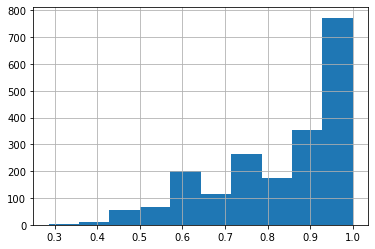

In [10]:
(processed_features.isna().sum(axis=1) / processed_features.shape[1]).sort_values(ascending=False).hist()

# Graph features

In [58]:
for rec in SeqIO.parse(filename, "nexus"):
	print(rec.id)
	print(repr(rec.seq))
	print(len(rec))

In [62]:
from Bio import Phylo
# load graph in format nexus.nex:
# ((((((((((((((((((((((Centipeda_cunninghamii:2.334467,Centipeda_minima:2.334467):0.095721,Centipeda_aotearoana:2.430188):0.012004,Centipeda_elatinoides:2.442192):18.460732,(((((Helichrysum_dimorphum:1.556045,Helichrysum_depressum:1.556045,Helichrysum_coralloides:1.556045,(Helichrysum_filicaule:0.528987,Helichrysum_lanceolatum:0.528987):1.027059):0.528609,(Pseudognaphalium_luteoalbum:0.274923,Pseudognaphalium_ephemerum:0.274923):1.809731):2.322955,(((Raoulia_subulata:1.375638,Raoulia_subsericea:1.375638,Raoulia_petriensis:1.375638,Raoulia_parkii:1.375638,Raoulia_haastii:1.375638,Raoulia_cinerea:1.375638,Raoulia_bryoides:1.375638,Raoulia_beauverdii:1.375638,Raoulia_apicinigra:1.375638,Raoulia_albosericea:1.375638,(((((Raoulia_buchananii:0.002972,Raoulia_goyenii:0.002972):0.348722,Raoulia_eximia:0.351694):0.101627,Raoulia_rubra:0.453321):0.21017,Raoulia_youngii:0.663491):0.431453,(((Raoulia_glabra:0.373744,Raoulia_australis:0.373744):0.111268,(Raoulia_monroi:0.246199,Raoulia_hookeri:0.246199):0.238813):0.489619,Raoulia_mammillaris:0.974631):0.120313):0.280695,(Raoulia_grandiflora:1.300999,Raoulia_hectorii:1.300999):0.07464):0.141717,(Rachelia_glaria:1.370926,Ewartiothamnus_sinclairii:1.370926):0.14643):0.008985,((...

# load graph in format nexus.nex:
filename = "allNZspecies.nexus.nex"
tree = Phylo.read(filename, "newick")

<Figure size 720x1800 with 0 Axes>

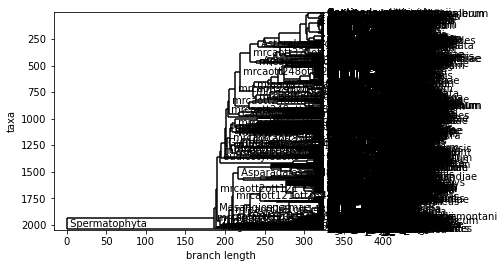

In [70]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 25))
Phylo.draw(tree, do_show=False)